# Causal mediation analysis 

The objective of this notebook is to develop a basic understanding of causal mediation analysis on a toy example.

In [19]:
import sklearn
from sklearn import cluster, datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Dataset

In [3]:
rng = np.random.RandomState(170)

### Create dataset features

n_samples = 10000
X, l = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
### Plot options

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(l) + 1),
        )
    )
)

markers = np.array(
    list(
        islice(
            cycle(
                [
                    ".",
                    "+",
                    "x",
                    "v",
                    "s",
                    "p",
                ]
            ),
            int(max(l) + 1),
        )
    )
)

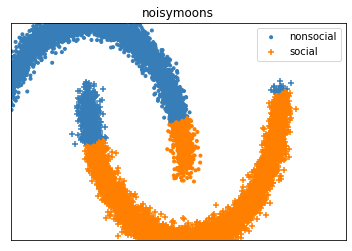

In [5]:
### Dataset visualisation

reg = LogisticRegression().fit(X, l)
l_fitted = reg.predict(X)
l_fitted
markers = np.array(['.', '+'], dtype=str)
labels = ['nonsocial', 'social']

# plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_fitted], marker=markers[y])
for i, c in enumerate(np.unique(l)):
    plt.scatter(X[:,0][l==c],X[:,1][l==c],color=colors[l_fitted][l==c], marker=markers[i], label=labels[i])
    
plt.plot()
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 1.5)
plt.xticks(())
plt.yticks(())
plt.title('noisymoons')
plt.legend()
plt.savefig('noisymoons.pdf')

In [6]:
# Treatments and other quantities

T = rng.choice([0,1], size=(n_samples,1))
np.mean(X, axis=0)
#mean_X = np.array([0.5, 0.25])
mean_X = np.array([0., 0.])

In [7]:
# Coefficients

reg = LinearRegression().fit(X, l)
reg.score(X, l), reg.coef_, reg.intercept_
beta_0 = reg.intercept_
beta_X = reg.coef_

beta_T = np.array([1])
beta_TX = np.array([0,0])
omega_T = 0.9

M_ = beta_0 + X.dot(beta_X) + omega_T*T.dot(beta_T) + (T*X).dot(beta_TX) + rng.normal(0, 0.1, size=T.shape[0])
M = np.expand_dims(M_, axis=-1)

gamma_0 = 0
gamma_X = np.array([0,0]) 
gamma_T = np.array([0.2])
gamma_M = np.array([1])
gamma_MT = np.array([0])
omega_M = 0.9

Y = gamma_0 + X.dot(gamma_X) + T.dot(gamma_T) + omega_M*M.dot(gamma_M) + (T*M).dot(gamma_MT) + rng.normal(0, 0.1, size=T.shape[0])

In [106]:
((T*X).dot(beta_TX)).shape
linear_X = beta_0 + X.dot(beta_X)
linear_T = omega_T*T.dot(beta_T)
linear_TX = (T*X).dot(beta_TX)
noise = rng.normal(0, 0.1, size=T.shape[0])

In [13]:
### Causal quantities

mean_M_t1 = beta_0 + mean_X.dot(beta_X) + mean_X.dot(beta_TX) + omega_T *beta_T
mean_M_t0 = beta_0 + mean_X.dot(beta_X)

theta_1 = gamma_T + gamma_MT.T.dot(mean_M_t1) # to do mean(m1) pour avoir un vecteur de taille dim_m
theta_0 = gamma_T + gamma_MT.T.dot(mean_M_t0)
#delta_1 = (gamma_T * t1 + m1.dot(gamma_m) + m1.dot(gamma_t_m) * t1 - gamma_t * t1 + m0.dot(gamma_m) + m0.dot(gamma_t_m) * t1).mean()
#delta_0 = (gamma_T * t0 + m1.dot(gamma_m) + m1.dot(gamma_t_m) * t0 - gamma_t * t0 + m0.dot(gamma_m) + m0.dot(gamma_t_m) * t0).mean()
delta_1 = (mean_X.dot(beta_TX) + omega_T * beta_T) * (omega_M * gamma_M + gamma_MT)
delta_0 = (mean_X.dot(beta_TX) + omega_T * beta_T) * (omega_M * gamma_M)

tau = gamma_T + omega_M * gamma_M * omega_T * beta_T
tau

## Causal effect estimation

In [20]:

CV_FOLDS = 5
ALPHAS = np.logspace(-5, 5, 8)

### Importance weighting

In [21]:
def get_classifier(regularization=False, forest=False, calibration=True, calib_method='sigmoid'):
    if regularization:
        cs = ALPHAS
    else:
        cs = [np.inf]
        
    if not forest:
        x_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
        xm_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS)
    else:
        x_clf = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=10)
        xm_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
    if calibration:
        x_clf = CalibratedClassifierCV(x_clf,
                                         method=calib_method)
        xm_clf = CalibratedClassifierCV(xm_clf, method=calib_method)
            
    return x_clf, xm_clf
    
def get_train_test_lists(crossfit, n): 
    if crossfit < 2:
        train_test_list = [[np.arange(n), np.arange(n)]]
    else:
        kf = KFold(n_splits=crossfit)
        train_test_list = list()
        for train_index, test_index in kf.split(x):
            train_test_list.append([train_index, test_index])
    return train_test_list

def estimate_probabilities(t, m, x, crossfit, classifier_x, classifier_xm):
    
    n = len(t)
    train_test_list = [[np.arange(n), np.arange(n)]]
    
    p_x, p_xm = [np.zeros(n) for h in range(2)]
    # compute propensity scores
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        m = m.reshape(-1, 1)
    
    train_test_list = get_train_test_lists(crossfit, n)
    
    for train_index, test_index in train_test_list:
        x_clf = classifier_x.fit(x[train_index, :], t[train_index])
        xm_clf = classifier_xm.fit(np.hstack((x, m))[train_index, :], t[train_index])
        p_x[test_index] = x_clf.predict_proba(x[test_index, :])[:, 1]
        p_xm[test_index] = xm_clf.predict_proba(
            np.hstack((x, m))[test_index, :])[:, 1]
        
    return p_x, p_xm

def SNIPW(y, t, m, x, trim, p_x, p_xm):
    """
    IPW estimator presented in
    HUBER, Martin. Identifying causal mechanisms (primarily) based on inverse
    probability weighting. Journal of Applied Econometrics, 2014,
    vol. 29, no 6, p. 920-943.

    results has 6 values
    - total effect
    - direct effect treated (\theta(1))
    - direct effect non treated (\theta(0))
    - indirect effect treated (\delta(1))
    - indirect effect untreated (\delta(0))
    - number of used observations (non trimmed)

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples, n_features_mediator)
            mediator value for each unit, can be continuous or binary, and
            multi-dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values


    trim    float
            Trimming rule for discarding observations with extreme propensity
            scores. In the absence of post-treatment confounders (w=NULL),
            observations with Pr(D=1|M,X)<trim or Pr(D=1|M,X)>(1-trim) are
            dropped. In the presence of post-treatment confounders
            (w is defined), observations with Pr(D=1|M,W,X)<trim or
            Pr(D=1|M,W,X)>(1-trim) are dropped.

    logit   boolean
            whether logit or pobit regression is used for propensity score
            legacy from the R package, here only logit is implemented

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5

    forest  boolean, default False
            whether to use a random forest model to estimate the propensity
            scores instead of logistic regression

    crossfit integer, default 0
             number of folds for cross-fitting

    clip    float
            limit to clip for numerical stability (min=clip, max=1-clip)
    """

    # trimming. Following causal weight code, not sure I understand
    # why we trim only on p_xm and not on p_x
    ind = ((p_xm > trim) & (p_xm < (1 - trim)))
    y, t, p_x, p_xm = y[ind], t[ind], p_x[ind], p_xm[ind]

    # note on the names, ytmt' = Y(t, M(t')), the treatment needs to be
    # binary but not the mediator
    p_x = np.clip(p_x, clip, 1 - clip)
    p_xm = np.clip(p_xm, clip, 1 - clip)

    y1m1 = np.sum(y * t / p_x) / np.sum(t / p_x)
    y1m0 = np.sum(y * t * (1 - p_xm) / (p_xm * (1 - p_x))) /\
        np.sum(t * (1 - p_xm) / (p_xm * (1 - p_x)))
    y0m0 = np.sum(y * (1 - t) / (1 - p_x)) /\
        np.sum((1 - t) / (1 - p_x))
    y0m1 = np.sum(y * (1 - t) * p_xm / ((1 - p_xm) * p_x)) /\
        np.sum((1 - t) * p_xm / ((1 - p_xm) * p_x))

    return(y1m1 - y0m0,
           y1m1 - y0m1,
           y1m0 - y0m0,
           y1m1 - y1m0,
           y0m1 - y0m0,
           np.sum(ind))

def IPW(y, t, m, x, trim, p_x, p_xm):
    """
    IPW estimator presented in
    HUBER, Martin. Identifying causal mechanisms (primarily) based on inverse
    probability weighting. Journal of Applied Econometrics, 2014,
    vol. 29, no 6, p. 920-943.

    results has 6 values
    - total effect
    - direct effect treated (\theta(1))
    - direct effect non treated (\theta(0))
    - indirect effect treated (\delta(1))
    - indirect effect untreated (\delta(0))
    - number of used observations (non trimmed)

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples, n_features_mediator)
            mediator value for each unit, can be continuous or binary, and
            multi-dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values


    trim    float
            Trimming rule for discarding observations with extreme propensity
            scores. In the absence of post-treatment confounders (w=NULL),
            observations with Pr(D=1|M,X)<trim or Pr(D=1|M,X)>(1-trim) are
            dropped. In the presence of post-treatment confounders
            (w is defined), observations with Pr(D=1|M,W,X)<trim or
            Pr(D=1|M,W,X)>(1-trim) are dropped.

    logit   boolean
            whether logit or pobit regression is used for propensity score
            legacy from the R package, here only logit is implemented

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5

    forest  boolean, default False
            whether to use a random forest model to estimate the propensity
            scores instead of logistic regression

    crossfit integer, default 0
             number of folds for cross-fitting

    clip    float
            limit to clip for numerical stability (min=clip, max=1-clip)
    """

    # trimming. Following causal weight code, not sure I understand
    # why we trim only on p_xm and not on p_x
    ind = ((p_xm > trim) & (p_xm < (1 - trim)))
    y, t, p_x, p_xm = y[ind], t[ind], p_x[ind], p_xm[ind]

    # note on the names, ytmt' = Y(t, M(t')), the treatment needs to be
    # binary but not the mediator
    p_x = np.clip(p_x, clip, 1 - clip)
    p_xm = np.clip(p_xm, clip, 1 - clip)

    y1m1 = np.mean(y * t / p_x) 
    y1m0 = np.mean(y * t * (1 - p_xm) / (p_xm * (1 - p_x))) 
    y0m0 = np.mean(y * (1 - t) / (1 - p_x)) 
    y0m1 = np.mean(y * (1 - t) * p_xm / ((1 - p_xm) * p_x)) 

    return(y1m1 - y0m0,
           y1m1 - y0m1,
           y1m0 - y0m0,
           y1m1 - y1m0,
           y0m1 - y0m0,
           np.sum(ind))





In [22]:
y = Y
t = T
m = M
x = X
trim=0
logit=True
regularization=False
forest=False
crossfit=0
clip=0.0
calibration=False
classifier_x, classifier_xm = get_classifier(regularization, forest, calibration)

In [24]:
p_x, p_xm = estimate_probabilities(t, m, x, crossfit, classifier_x, classifier_xm)
effects_IPW = IPW(y, t, m, x, trim, p_x, p_xm)
effects_SNIPW = SNIPW(y, t, m, x, trim, p_x, p_xm)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_IPW

In [26]:
print("IPW")
print("Direct effects")
print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
print("\\")
print("Indirect effects")
print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
print("\\")
print("Total effect")
print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

IPW
Direct effects
True theta1:[0.2], estimated theta1: -478403411903829.6
True theta0:[0.2], estimated theta0: -5.960267411051258e+25
\
Indirect effects
True delta1:[0.81], estimated delta1: 5.960267411051258e+25
True delta0:[0.81], estimated delta0: 478403411903829.1
\
Total effect
True tau:[1.01], estimated tau: -0.489


In [27]:
tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_SNIPW
print("SNIPW")
print("Direct effects")
print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
print("\\")
print("Indirect effects")
print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
print("\\")
print("Total effect")
print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

SNIPW
Direct effects
True theta1:[0.2], estimated theta1: -0.694
True theta0:[0.2], estimated theta0: -0.903
\
Indirect effects
True delta1:[0.81], estimated delta1: 0.893
True delta0:[0.81], estimated delta0: 0.684
\
Total effect
True tau:[1.01], estimated tau: -0.01


### Ordinary least squares

In [ ]:
def ols_mediation(y, t, m, x, interaction=False, regularization=True):
    """
    found an R implementation https://cran.r-project.org/package=regmedint

    implements very simple model of mediation
    Y ~ X + T + M
    M ~ X + T
    estimation method is product of coefficients

    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, can be continuous or binary, and
            is necessary in 1D

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    interaction boolean, default=False
                whether to include interaction terms in the model
                not implemented here, just for compatibility of signature
                function

    regularization boolean, default True
                   whether to use regularized models (logistic or
                   linear regression). If True, cross-validation is used
                   to chose among 8 potential log-spaced values between
                   1e-5 and 1e5

    """
    if regularization:
        alphas = ALPHAS
    else:
        alphas = [0.0]
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        m = m.reshape(-1, 1)
    if len(t.shape) == 1:
        t = t.reshape(-1, 1)
    coef_t_m = np.zeros(m.shape[1])
    for i in range(m.shape[1]):
        m_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)\
            .fit(np.hstack((x, t)), m[:, i])
        coef_t_m[i] = m_reg.coef_[-1]
    y_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)\
        .fit(np.hstack((x, t, m)), y.ravel())

    # return total, direct and indirect effect
    direct_effect = y_reg.coef_[x.shape[1]]
    indirect_effect = sum(y_reg.coef_[x.shape[1] + 1:] * coef_t_m)
    return [direct_effect + indirect_effect,
            direct_effect,
            direct_effect,
            indirect_effect,
            indirect_effect,
            None]


In [126]:
def get_regressions(regularization=False, interaction=False, forest=False, calibration=True, calib_method='sigmoid'):
    if regularization:
        cs = ALPHAS
    else:
        cs = [np.inf]
        
    # mu_tm, f_mtx, and p_x model fitting
    if not forest:
        y_reg = RidgeCV(alphas=alphas, cv=CV_FOLDS)
        pre_m_prob = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS).fit(
            get_interactions(interaction, t, x)[train_index, :], m[train_index]
        )
        pre_p_x_clf = LogisticRegressionCV(Cs=cs, cv=CV_FOLDS).fit(
            x[train_index, :], t[train_index]
        )
    else:
        y_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
        pre_m_prob = RandomForestClassifier(
            n_estimators=100, min_samples_leaf=10
        )
        pre_p_x_clf = RandomForestClassifier(
            n_estimators=100, min_samples_leaf=10
        )
    if calibration:
        m_prob = CalibratedClassifierCV(pre_m_prob, method=calib_method)
        p_x_clf = CalibratedClassifierCV(pre_p_x_clf, method=calib_method)
    else:
        m_prob = pre_m_prob
        p_x_clf = pre_p_x_clf
            
    return y_reg, m_prob, p_x_clf
    
def get_train_test_lists(crossfit, n): 
    if crossfit < 2:
        train_test_list = [[np.arange(n), np.arange(n)]]
    else:
        kf = KFold(n_splits=crossfit)
        train_test_list = list(kf.split(x))
        
    return train_test_list

def estimate_probabilities(t, m, x, crossfit, classifier_x, classifier_xm):
    
    n = len(t)
    train_test_list = [[np.arange(n), np.arange(n)]]
    
    p_x, p_xm = [np.zeros(n) for h in range(2)]
    # compute propensity scores
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(m.shape) == 1:
        m = m.reshape(-1, 1)
    
    train_test_list = get_train_test_lists(crossfit, n)
    
    for train_index, test_index in train_test_list:
        x_clf = classifier_x.fit(x[train_index, :], t[train_index])
        xm_clf = classifier_xm.fit(np.hstack((x, m))[train_index, :], t[train_index])
        p_x[test_index] = x_clf.predict_proba(x[test_index, :])[:, 1]
        p_xm[test_index] = xm_clf.predict_proba(
            np.hstack((x, m))[test_index, :])[:, 1]
        
    return p_x, p_xm

def get_interactions(interaction, *args):
    """
    this function provides interaction terms between different groups of
    variables (confounders, treatment, mediators)
    Inputs
    --------
    interaction     boolean
                    whether to compute interaction terms

    *args           flexible, one or several arrays
                    blocks of variables between which interactions should be
                    computed
    Returns
    --------
    Examples
    --------
    >>> x = np.arange(6).reshape(3, 2)
    >>> t = np.ones((3, 1))
    >>> m = 2 * np.ones((3, 1))
    >>> get_interactions(False, x, t, m)
    array([[0., 1., 1., 2.],
           [2., 3., 1., 2.],
           [4., 5., 1., 2.]])
    >>> get_interactions(True, x, t, m)
    array([[ 0.,  1.,  1.,  2.,  0.,  1.,  0.,  2.,  2.],
           [ 2.,  3.,  1.,  2.,  2.,  3.,  4.,  6.,  2.],
           [ 4.,  5.,  1.,  2.,  4.,  5.,  8., 10.,  2.]])
    """
    variables = list(args)
    for index, var in enumerate(variables):
        if len(var.shape) == 1:
            variables[index] = var.reshape(-1,1)
    pre_inter_variables = np.hstack(variables)
    if not interaction:
        return pre_inter_variables
    new_cols = list()
    for i, var in enumerate(variables[:]):
        for j, var2 in enumerate(variables[i+1:]):
            for ii in range(var.shape[1]):
                for jj in range(var2.shape[1]):
                    new_cols.append((var[:, ii] * var2[:, jj]).reshape(-1, 1))
    new_vars = np.hstack(new_cols)
    result = np.hstack((pre_inter_variables, new_vars))
    return result

def multiply_robust_efficient(
    y,
    t,
    m,
    x,
    interaction=False,
    forest=False,
    crossfit=0,
    trim=0.01,
    regularization=True,
    calibration=True,
    calib_method="sigmoid",
):
    """
    Presented in Eric J. Tchetgen Tchetgen. Ilya Shpitser.
    "Semiparametric theory for causal mediation analysis: Efficiency bounds,
    multiple robustness and sensitivity analysis."
    Ann. Statist. 40 (3) 1816 - 1845, June 2012.
    https://doi.org/10.1214/12-AOS990

    Parameters
    ----------
    y : array-like, shape (n_samples)
        Outcome value for each unit, continuous

    t : array-like, shape (n_samples)
        Treatment value for each unit, binary

    m : array-like, shape (n_samples)
        Mediator value for each unit, binary and unidimensional

    x : array-like, shape (n_samples, n_features_covariates)
        Covariates value for each unit, continuous

    interaction : boolean, default=False
        Whether to include interaction terms in the model
        interactions are terms XT, TM, MX

    forest : boolean, default=False
        Whether to use a random forest model to estimate the propensity
        scores instead of logistic regression, and outcome model instead
        of linear regression

    crossfit : integer, default=0
        Number of folds for cross-fitting. If crossfit<2, no cross-fitting is applied

    trim : float, default=0.01
        Limit to trim p_x and f_mtx for numerical stability (min=trim, max=1-trim)

    regularization : boolean, default=True
        Whether to use regularized models (logistic or linear regression).
        If True, cross-validation is used to chose among 8 potential
        log-spaced values between 1e-5 and 1e5

    calibration : boolean, default=True
        Whether to add a calibration step so that the classifier used to estimate
        the treatment propensity score and the density of the (binary) mediator.
        Calibration ensures the output of the [predict_proba](https://scikit-learn.org/stable/glossary.html#term-predict_proba)
        method can be directly interpreted as a confidence level.

    calib_method : str, default="sigmoid"
        Which calibration method to use.
        Implemented calibration methods are "sigmoid" and "isotonic".


    Returns
    -------
    total : float
        Average total effect.
    direct1 : float
        Direct effect on the exposed.
    direct0 : float
        Direct effect on the unexposed,
    indirect1 : float
        Indirect effect on the exposed.
    indirect0 : float
        Indirect effect on the unexposed.
    n_discarded : int
        Number of discarded samples due to trimming.


    Raises
    ------
    ValueError
        - If t or y are multidimensional.
        - If x, t, m, or y don't have the same length.
        - If m is not binary.
    """
    # Format checking
    if len(y) != len(y.ravel()):
        raise ValueError("Multidimensional y is not supported")
    if len(t) != len(t.ravel()):
        raise ValueError("Multidimensional t is not supported")
    if len(m) != len(m.ravel()):
        raise ValueError("Multidimensional m is not supported")

    n = len(y)
    if len(x.shape) == 1:
        x.reshape(n, 1)
    if len(m.shape) == 1:
        m.reshape(n, 1)

    dim_m = m.shape[1]
    if n * dim_m != sum(m.ravel() == 1) + sum(m.ravel() == 0):
        raise ValueError("m is not binary")

    y = y.ravel()
    t = t.ravel()
    m = m.ravel()
    if n != len(x) or n != len(m) or n != len(t):
        raise ValueError("Inputs don't have the same number of observations")

    # Initialisation
    (
        p_x,  # P(T=1|X)
        f_00x,  # f(M=0|T=0,X)
        f_01x,  # f(M=0|T=1,X)
        f_10x,  # f(M=1|T=0,X)
        f_11x,  # f(M=1|T=1,X)
        f_m0x,  # f(M|T=0,X)
        f_m1x,  # f(M|T=1,X)
        mu_t1,  # E[Y|T=1,M,X]
        mu_t0,  # E[Y|T=0,M,X]
        mu_t1_m1,  # E[Y|T=1,M=1,X]
        mu_t1_m0,  # E[Y|T=1,M=0,X]
        mu_t0_m1,  # E[Y|T=0,M=1,X]
        mu_t0_m0,  # E[Y|T=0,M=0,X]
        E_mu_t0_t0,  # E[E[Y|T=0,M,X]|T=0,X]
        E_mu_t0_t1,  # E[E[Y|T=0,M,X]|T=1,X]
        E_mu_t1_t0,  # E[E[Y|T=1,M,X]|T=0,X]
        E_mu_t1_t1,  # E[E[Y|T=1,M,X]|T=1,X]
    ) = [np.zeros(n) for _ in range(17)]
    t0, m0 = np.zeros((n, 1)), np.zeros((n, 1))
    t1, m1 = np.ones((n, 1)), np.ones((n, 1))
    n_discarded = 0

    if regularization:
        alphas, cs = ALPHAS, ALPHAS
    else:
        alphas, cs = [0.0], [np.inf]

    train_test_list = get_train_test_lists(crossfit, n)

    # Cross-fitting loop
    for train_index, test_index in train_test_list:
        # Index declaration
        test_ind = np.arange(len(test_index))
        ind_t0 = t[test_index] == 0

        y_reg, m_prob, p_x_clf  = get_regressions(regularization, interaction, forest, calibration)
        y_reg.fit(
            get_interactions(interaction, x, t, m)[train_index, :], y[train_index]
        )
        m_prob.fit(
                get_interactions(interaction, t, x)[train_index, :], m[train_index]
            )
        p_x_clf.fit(
                x[train_index, :], t[train_index]
            )

        # predict P(T=1|X)
        p_x[test_index] = p_x_clf.predict_proba(x[test_index, :])[:, 1]

        # predict f(M=m|T=t,X)
        res = m_prob.predict_proba(get_interactions(interaction, t0, x)[test_index, :])
        f_00x[test_index] = res[:, 0]
        f_01x[test_index] = res[:, 1]
        res = m_prob.predict_proba(get_interactions(interaction, t1, x)[test_index, :])
        f_10x[test_index] = res[:, 0]
        f_11x[test_index] = res[:, 1]

        # predict f(M|T=t,X)
        f_m0x[test_index] = m_prob.predict_proba(
            get_interactions(interaction, t0, x)[test_index, :]
        )[test_ind, m[test_index]]
        f_m1x[test_index] = m_prob.predict_proba(
            get_interactions(interaction, t1, x)[test_index, :]
        )[test_ind, m[test_index]]

        # predict E[Y|T=t,M,X]
        mu_t1[test_index] = y_reg.predict(
            get_interactions(interaction, x, t1, m)[test_index, :]
        )
        mu_t0[test_index] = y_reg.predict(
            get_interactions(interaction, x, t0, m)[test_index, :]
        )

        # predict E[Y|T=t,M=m,X]
        mu_t0_m0[test_index] = y_reg.predict(
            get_interactions(interaction, x, t0, m0)[test_index, :]
        )
        mu_t0_m1[test_index] = y_reg.predict(
            get_interactions(interaction, x, t0, m1)[test_index, :]
        )
        mu_t1_m1[test_index] = y_reg.predict(
            get_interactions(interaction, x, t1, m1)[test_index, :]
        )
        mu_t1_m0[test_index] = y_reg.predict(
            get_interactions(interaction, x, t1, m0)[test_index, :]
        )

        # E[E[Y|T=1,M=m,X]|T=t,X] model fitting
        reg_y_t1m1_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t1_m1[test_index][ind_t0]
        )
        reg_y_t1m0_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t1_m0[test_index][ind_t0]
        )
        reg_y_t1m1_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t1_m1[test_index][~ind_t0]
        )
        reg_y_t1m0_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t1_m0[test_index][~ind_t0]
        )

        # predict E[E[Y|T=1,M=m,X]|T=t,X]
        E_mu_t1_t0[test_index] = (
            reg_y_t1m0_t0.predict(x[test_index, :]) * f_00x[test_index]
            + reg_y_t1m1_t0.predict(x[test_index, :]) * f_01x[test_index]
        )
        E_mu_t1_t1[test_index] = (
            reg_y_t1m0_t1.predict(x[test_index, :]) * f_10x[test_index]
            + reg_y_t1m1_t1.predict(x[test_index, :]) * f_11x[test_index]
        )

        # E[E[Y|T=0,M=m,X]|T=t,X] model fitting
        reg_y_t0m1_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t0_m1[test_index][ind_t0]
        )
        reg_y_t0m0_t0 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][ind_t0, :], mu_t0_m0[test_index][ind_t0]
        )
        reg_y_t0m1_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t0_m1[test_index][~ind_t0]
        )
        reg_y_t0m0_t1 = RidgeCV(alphas=alphas, cv=CV_FOLDS).fit(
            x[test_index, :][~ind_t0, :], mu_t0_m0[test_index][~ind_t0]
        )

        # predict E[E[Y|T=0,M=m,X]|T=t,X]
        E_mu_t0_t0[test_index] = (
            reg_y_t0m0_t0.predict(x[test_index, :]) * f_00x[test_index]
            + reg_y_t0m1_t0.predict(x[test_index, :]) * f_01x[test_index]
        )
        E_mu_t0_t1[test_index] = (
            reg_y_t0m0_t1.predict(x[test_index, :]) * f_10x[test_index]
            + reg_y_t0m1_t1.predict(x[test_index, :]) * f_11x[test_index]
        )

    # trimming
    p_x_trim = p_x != np.clip(p_x, trim, 1 - trim)
    f_m0x_trim = f_m0x != np.clip(f_m0x, trim, 1 - trim)
    f_m1x_trim = f_m1x != np.clip(f_m1x, trim, 1 - trim)
    trimmed = p_x_trim + f_m0x_trim + f_m1x_trim

    var_name = ["t", "y", "p_x", "f_m0x", "f_m1x", "mu_t1", "mu_t0"]
    var_name += ["E_mu_t1_t1", "E_mu_t0_t0", "E_mu_t1_t0", "E_mu_t0_t1"]

    for var in var_name:
        exec(f"{var} = {var}[~trimmed]")
    n_discarded += np.sum(trimmed)

    # ytmt computing
    y1m1 = t / p_x * (y - E_mu_t1_t1) + E_mu_t1_t1
    y0m0 = (1 - t) / (1 - p_x) * (y - E_mu_t0_t0) + E_mu_t0_t0
    y1m0 = (
        (t / p_x) * (f_m0x / f_m1x) * (y - mu_t1)
        + (1 - t) / (1 - p_x) * (mu_t1 - E_mu_t1_t0)
        + E_mu_t1_t0
    )
    y0m1 = (
        (1 - t) / (1 - p_x) * (f_m1x / f_m0x) * (y - mu_t0)
        + t / p_x * (mu_t0 - E_mu_t0_t1)
        + E_mu_t0_t1
    )

    # effects computing
    total = np.mean(y1m1 - y0m0)
    direct1 = np.mean(y1m1 - y0m1)
    direct0 = np.mean(y1m0 - y0m0)
    indirect1 = np.mean(y1m1 - y1m0)
    indirect0 = np.mean(y0m1 - y0m0)

    return total, direct1, direct0, indirect1, indirect0, n_discarded



In [128]:
effects_MR = multiply_robust_efficient(y, t, m, x)

ValueError: m is not binary

In [134]:
effects_linear = ols_mediation(y, t, m, x)

tau_hat, theta_1_hat, theta_0_hat, delta_1_hat, delta_0_hat, n_non_trimmed = effects_linear
print("Linear coefficients")
print("Direct effects")
print("True theta1:{}, estimated theta1: {}".format(theta_1, round(theta_1_hat,3)))
print("True theta0:{}, estimated theta0: {}".format(theta_0, round(theta_0_hat,3)))
print("\\")
print("Indirect effects")
print("True delta1:{}, estimated delta1: {}".format(delta_1, round(delta_1_hat,3)))
print("True delta0:{}, estimated delta0: {}".format(delta_0, round(delta_0_hat,3)))
print("\\")
print("Total effect")
print("True tau:{}, estimated tau: {}".format(tau, round(tau_hat,3)))

Linear coefficients
Direct effects
True theta1:[0.2], estimated theta1: 0.195
True theta0:[0.2], estimated theta0: 0.195
\
Indirect effects
True delta1:[0.81], estimated delta1: 0.818
True delta0:[0.81], estimated delta0: 0.818
\
Total effect
True tau:[1.01], estimated tau: 1.013
